In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk xgboost shap lime transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [ ]:
df = pd.read_csv('/content/email spam or not.csv')
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


<Axes: title={'center': 'Spam vs Not Spam'}, xlabel='label'>

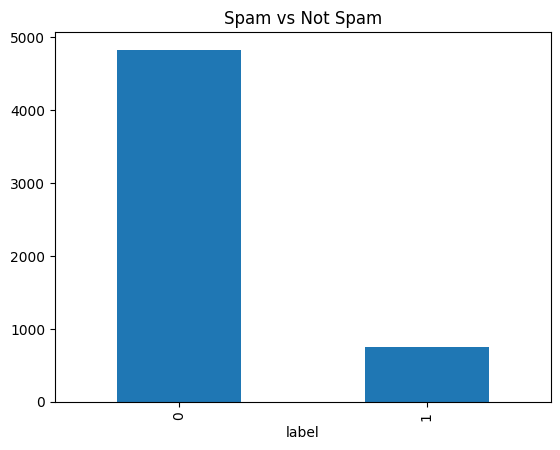

In [ ]:
df['label'].value_counts().plot(kind='bar', title='Spam vs Not Spam')

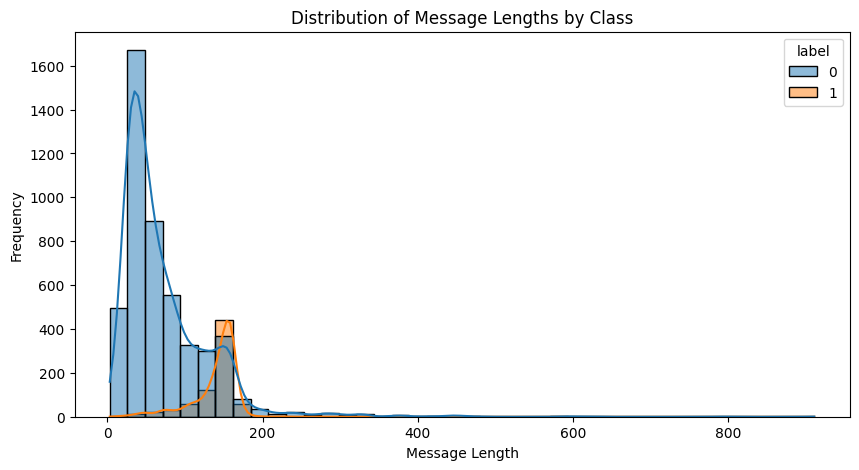

In [ ]:

df['text_length'] = df['sms'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='text_length', hue='label', bins=40, kde=True)
plt.title('Distribution of Message Lengths by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['sms'].apply(clean_text)


Content Visualization	WordCloud for Spam and Ham

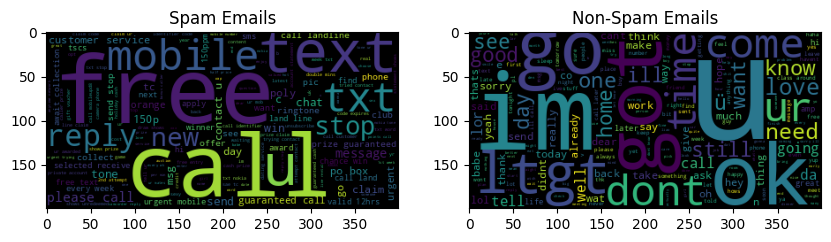

In [ ]:
from wordcloud import WordCloud

spam_words = ' '.join(df[df['label']==1]['clean_text'])
not_spam_words = ' '.join(df[df['label']==0]['clean_text'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud().generate(spam_words))
plt.title('Spam Emails')

plt.subplot(1,2,2)
plt.imshow(WordCloud().generate(not_spam_words))
plt.title('Non-Spam Emails')
plt.show()


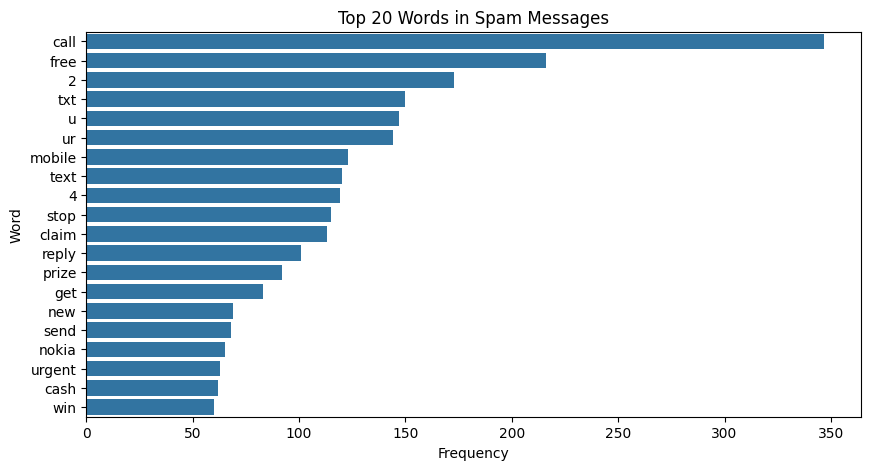

In [ ]:
#Feature Engineering
from collections import Counter

# Top 20 spam words
spam_word_list = ' '.join(df[df['label']==1]['clean_text']).split()
spam_freq = Counter(spam_word_list).most_common(20)

# Plot
spam_df = pd.DataFrame(spam_freq, columns=['word', 'count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=spam_df, x='count', y='word')
plt.title('Top 20 Words in Spam Messages')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

le = LabelEncoder()
y = le.fit_transform(df['label'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred),
        'ROC AUC': roc_auc_score(y_test, pred)
    }



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


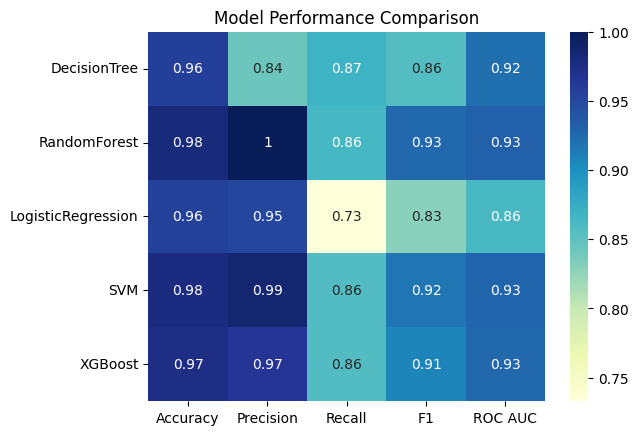

In [ ]:
result_df = pd.DataFrame(results).T
sns.heatmap(result_df, annot=True, cmap='YlGnBu')
plt.title("Model Performance Comparison")
plt.show()


In [ ]:
# Create the Voting Classifier
voting = VotingClassifier(
    estimators=[
        ('rf', models['RandomForest']),
        ('svm', models['SVM']),
        ('lr', models['LogisticRegression'])
    ],
    voting='soft'
)

# Define parameter grid for SVM
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:46:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:46:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:46:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:46:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:47:00] WARNING: /w

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier()),
                                                    ('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric='logloss',
                                                                   feature_types=None,
                                                                   feature_weights=None,
                                                                   gam...
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...)),
                                                    ('lr',
                                                     LogisticRegression())],
                                        voting='soft'),
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5, 7]})

 Model Performance:
 Accuracy  : 0.9623
 Precision : 0.9542
 Recall    : 0.7764
 F1 Score  : 0.8562


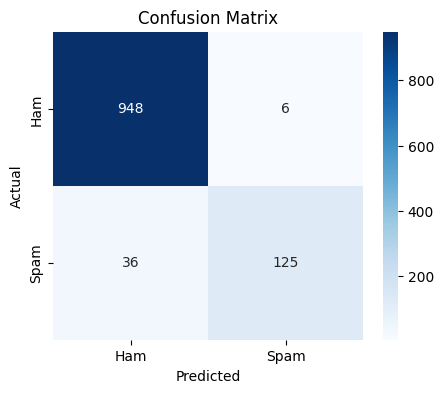


 Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.99      0.98       954
        Spam       0.95      0.78      0.86       161

    accuracy                           0.96      1115
   macro avg       0.96      0.89      0.92      1115
weighted avg       0.96      0.96      0.96      1115



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model_pipeline.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(" Model Performance:")
print(f" Accuracy  : {accuracy:.4f}")
print(f" Precision : {precision:.4f}")
print(f" Recall    : {recall:.4f}")
print(f" F1 Score  : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


In [ ]:
import joblib
joblib.dump(grid.best_estimator_, 'spam_model.pkl')


['spam_model.pkl']

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['Not Spam', 'Spam'])
exp = explainer.explain_instance(df['clean_text'].iloc[0], lr_pipeline.predict_proba, num_features=10)
exp.show_in_notebook()
